In [60]:
import warnings
#from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [61]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
"""
from PIL import Image
from IPython.display import display


import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.offline as py
import seaborn as sns

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from lofo import LOFOImportance, Dataset, plot_importance
"""
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [62]:
file_path = "rnv_data.xlsx"
sheet_name='order_line_data'
df = pd.read_excel(file_path, sheet_name=sheet_name)
df_raw = df.copy()

In [63]:
###################################### EXPLORE ######################################

In [64]:
df.head(1)

,line_type,mkp_name,mkp_order_no,order_date,ordoro_id,sku,item_sale_price,item_tax,shipping_sale,total_per_sku,title,supplier_name,order_status,item_cost,cancelled_value,transport_cost_est,first_pick_date,last_delivery_date,courier,mage_mkp_commission,mkp_estimated_commission,mkp_actual_commission,order_grand_total,ordoro_import_date,tool_import_date,max_shipping_date,max_delivery_date,cd_status,is_clogistique_order,line_status,transport_cost_actual,order_place_time,order_prep_time,order_delivery_time,order_total_time,gm_estimated
0,ORDER LINE,CDiscount,2009161727KUPJE,2020-09-16 15:27:00,1-300055647,KK-KKLJOYBLU00000,69.950,0,9.950,79.900,NaN,KK,shipped,0.000,0.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,NaN,1.920,0.000,13.900,81.820,2020-09-16 19:46:00,2020-09-16 19:51:00,2020-09-30,2020-10-09,WaitingForShipmentAcceptation,No,Awaiting shipment,0,16,0,0,16,51.080


In [65]:
df.shape

(5000, 36)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   line_type                 5000 non-null   object        
 1   mkp_name                  5000 non-null   object        
 2   mkp_order_no              5000 non-null   object        
 3   order_date                5000 non-null   datetime64[ns]
 4   ordoro_id                 5000 non-null   object        
 5   sku                       5000 non-null   object        
 6   item_sale_price           5000 non-null   float64       
 7   item_tax                  5000 non-null   int64         
 8   shipping_sale             5000 non-null   float64       
 9   total_per_sku             5000 non-null   float64       
 10  title                     0 non-null      float64       
 11  supplier_name             5000 non-null   object        
 12  order_status        

In [67]:
round(df.isna().sum() /len(df) *100,2)
# title, courier, cd_status are the columns having missing values more than %25 percent

line_type                    0.000
mkp_name                     0.000
mkp_order_no                 0.000
order_date                   0.000
ordoro_id                    0.000
sku                          0.000
item_sale_price              0.000
item_tax                     0.000
shipping_sale                0.000
total_per_sku                0.000
title                      100.000
supplier_name                0.000
order_status                 0.000
item_cost                    0.000
cancelled_value              0.000
transport_cost_est           0.000
first_pick_date              0.000
last_delivery_date           0.000
courier                     31.660
mage_mkp_commission          0.000
mkp_estimated_commission     0.000
mkp_actual_commission        0.000
order_grand_total            0.000
ordoro_import_date           0.000
tool_import_date             0.000
max_shipping_date            0.000
max_delivery_date            0.000
cd_status                   47.120
is_clogistique_order

In [68]:
df['order_month'] = df['order_date'].dt.month
df['order_week'] = df['order_date'].dt.isocalendar().week
df['order_year'] = df['order_date'].dt.year
df['order_hour'] = df['order_date'].dt.hour

In [69]:
def get_categorical_and_numeric_columns(dataframe, number_of_unique_classes):
    categorical_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) <= number_of_unique_classes
                          or dataframe[col].dtype == "category"]
    
    new_categorical_columns = []
    for cat_cols in categorical_columns:
        new_categorical_columns.append(cat_cols)
    print(new_categorical_columns)
    numeric_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > number_of_unique_classes
                       and dataframe[col].dtype != "category" or col not in new_categorical_columns]
    #numeric_columns.remove(cons.target_variable)  
    return new_categorical_columns, numeric_columns

def unique_value_analysis(dataframe, number_of_unique_classes):
    check_flag = 0
    for i in range(0, len(number_of_unique_classes)):
        cat_cols, num_cols = get_categorical_and_numeric_columns(dataframe, number_of_unique_classes[i])
        print('Number of Unique Value:',number_of_unique_classes[i],' Number of Categorical Value:',len(cat_cols),' Number of Numerical Value: ', len(num_cols))
        if check_flag < len(cat_cols)*1.1 and check_flag > 0:
            return number_of_unique_classes[i]
        else:
            check_flag = len(cat_cols)

In [70]:
threshold_value = unique_value_analysis(df,[2, 3, 5, 10, 20, 50])
print("threshold_value: ", threshold_value)
cat_cols, num_cols = get_categorical_and_numeric_columns(df, 50)

['item_tax', 'title', 'is_clogistique_order', 'transport_cost_actual', 'order_month', 'order_year']
Number of Unique Value: 2  Number of Categorical Value: 6  Number of Numerical Value:  34
['line_type', 'item_tax', 'title', 'order_status', 'courier', 'is_clogistique_order', 'line_status', 'transport_cost_actual', 'order_month', 'order_year']
Number of Unique Value: 3  Number of Categorical Value: 10  Number of Numerical Value:  30
threshold_value:  3
['line_type', 'mkp_name', 'item_tax', 'shipping_sale', 'title', 'supplier_name', 'order_status', 'cancelled_value', 'courier', 'max_shipping_date', 'cd_status', 'is_clogistique_order', 'line_status', 'transport_cost_actual', 'order_place_time', 'order_prep_time', 'order_delivery_time', 'order_total_time', 'order_month', 'order_week', 'order_year', 'order_hour']


In [71]:
cat_cols

['line_type',
 'mkp_name',
 'item_tax',
 'shipping_sale',
 'title',
 'supplier_name',
 'order_status',
 'cancelled_value',
 'courier',
 'max_shipping_date',
 'cd_status',
 'is_clogistique_order',
 'line_status',
 'transport_cost_actual',
 'order_place_time',
 'order_prep_time',
 'order_delivery_time',
 'order_total_time',
 'order_month',
 'order_week',
 'order_year',
 'order_hour']

In [72]:
num_cols

['mkp_order_no',
 'order_date',
 'ordoro_id',
 'sku',
 'item_sale_price',
 'total_per_sku',
 'item_cost',
 'transport_cost_est',
 'first_pick_date',
 'last_delivery_date',
 'mage_mkp_commission',
 'mkp_estimated_commission',
 'mkp_actual_commission',
 'order_grand_total',
 'ordoro_import_date',
 'tool_import_date',
 'max_delivery_date',
 'gm_estimated']

## CATEGORICAL COLUMNS ANALYSIS

In [73]:
def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        fig, ax = plt.subplots(1, 2)
        ax = np.reshape(ax, (1, 2))
        ax[0, 0] = sns.countplot(x=dataframe[col_name], color="green", ax=ax[0, 0])
        ax[0, 0].set_ylabel('Count')
        ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=-45)
        ax[0, 1] = plt.pie(dataframe[col_name].value_counts().values, labels=dataframe[col_name].value_counts().keys(),
                           colors=sns.color_palette('bright'), shadow=True, autopct='%.0f%%')
        plt.title("Percent")
        fig.set_size_inches(10, 6)
        fig.suptitle('Analysis of Categorical Variables', fontsize=13)
        plt.show()

                     line_type  Ratio
line_type                            
ORDER LINE                4980 99.600
FULL REPLACEMENT            13  0.260
PARTIAL REPLACEMENT          7  0.140


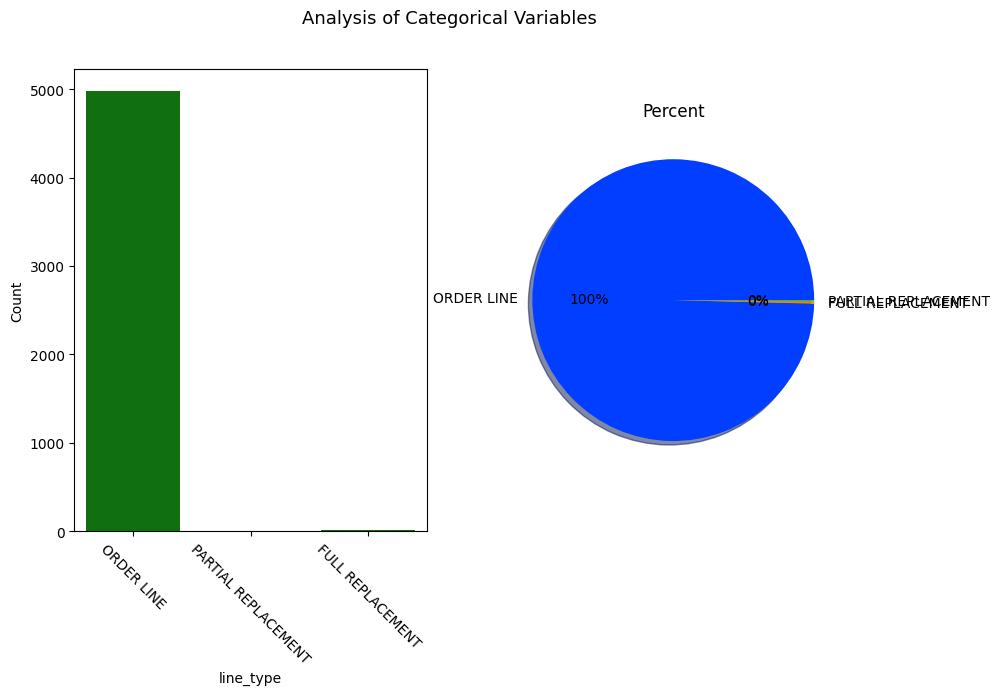

               mkp_name  Ratio
mkp_name                      
CDiscount          2219 44.380
Monechelle         1516 30.320
conforama           681 13.620
CLogistique         427  8.540
Fnac                107  2.140
Darty                25  0.500
RueDuCommerce        16  0.320
PriceMinister         9  0.180


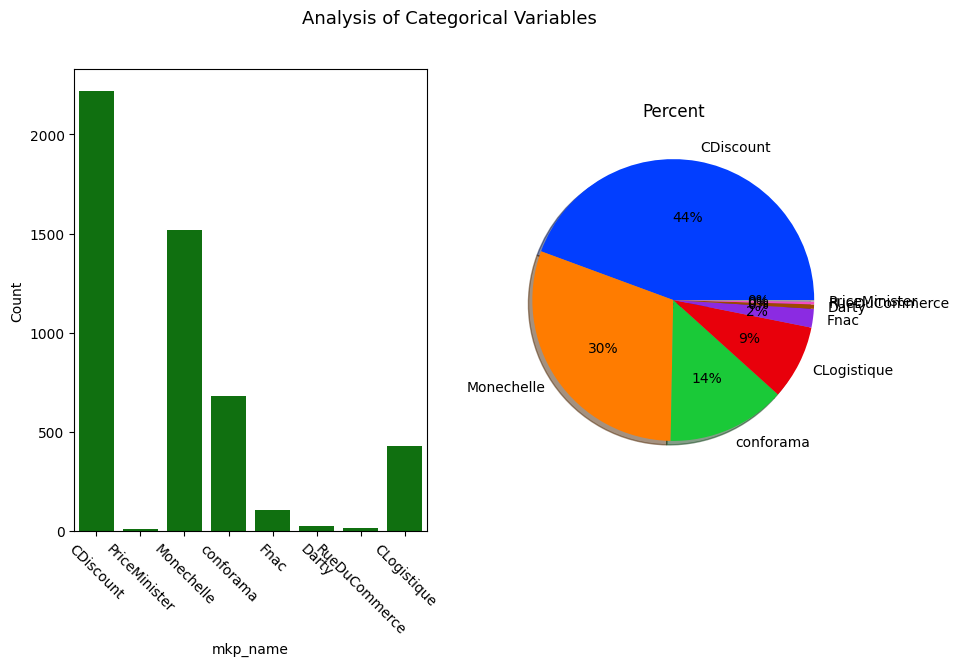

          item_tax   Ratio
item_tax                  
0             5000 100.000


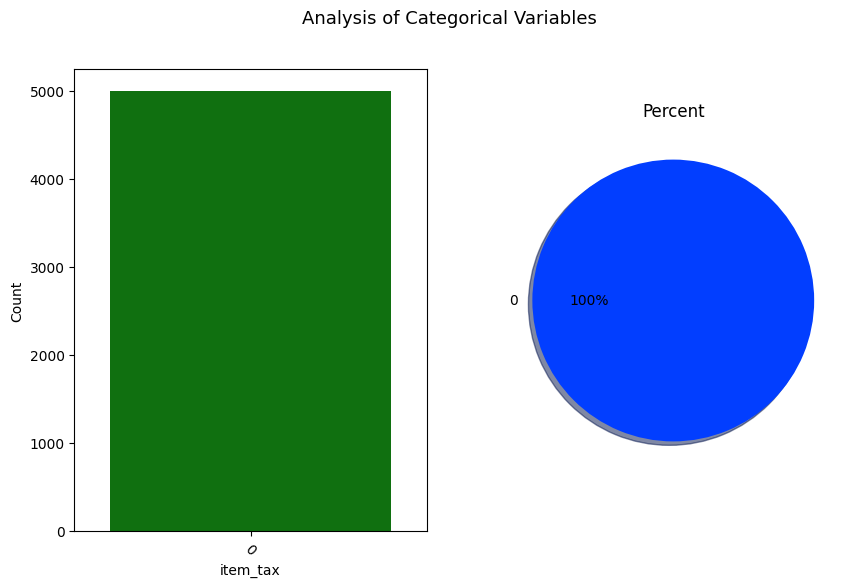

               shipping_sale  Ratio
shipping_sale                      
0.000                   1963 39.260
19.950                  1801 36.020
9.950                    973 19.460
4.980                     62  1.240
12.480                    44  0.880
14.950                    20  0.400
9.990                     16  0.320
19.990                    16  0.320
3.990                     13  0.260
9.980                     12  0.240
13.280                    12  0.240
6.870                      8  0.160
6.650                      6  0.120
8.320                      6  0.120
1.500                      6  0.120
34.950                     6  0.120
2.990                      5  0.100
39.950                     5  0.100
49.950                     4  0.080
24.950                     4  0.080
3.320                      3  0.060
2.070                      2  0.040
0.970                      2  0.040
14.980                     2  0.040
1.200                      2  0.040
50.000                     2

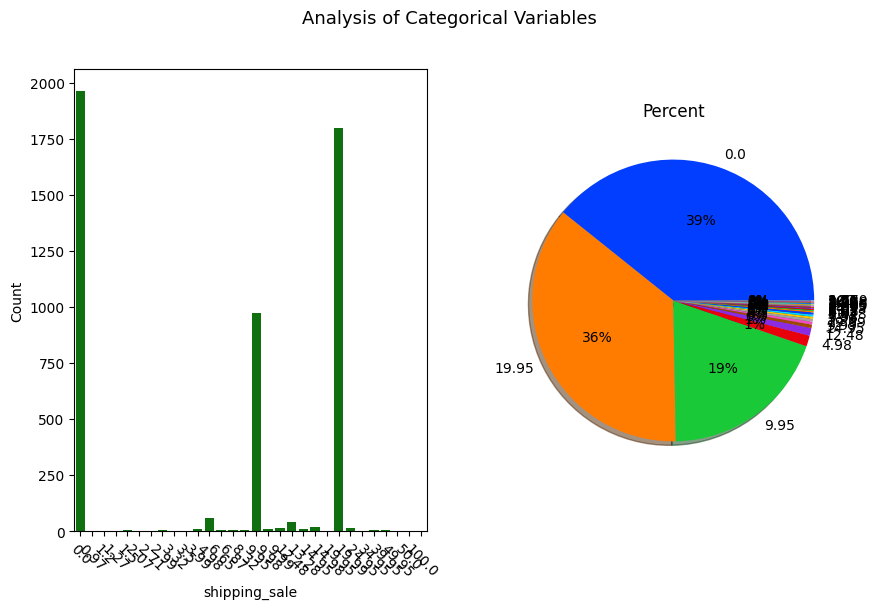

Empty DataFrame
Columns: [title, Ratio]
Index: []


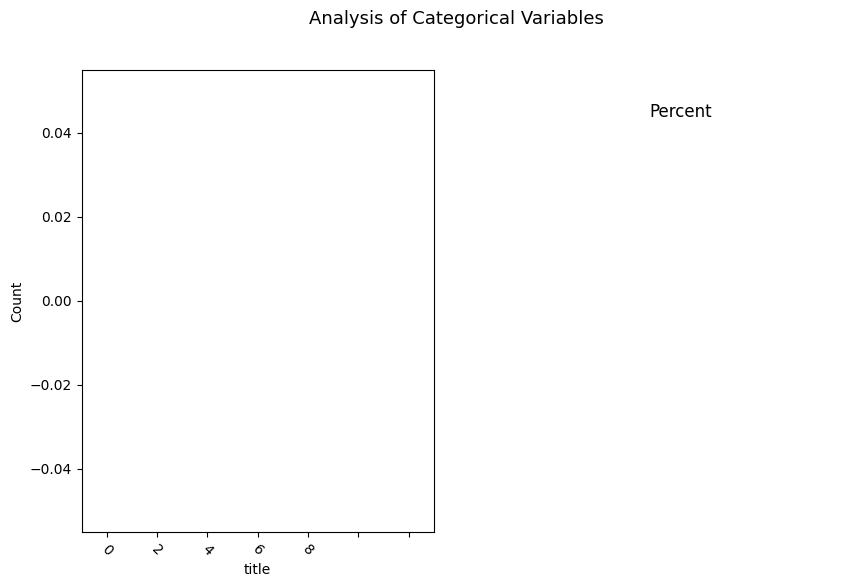

               supplier_name  Ratio
supplier_name                      
TOP                     2408 48.160
AKO                     1234 24.680
MOB                      412  8.240
KD                       169  3.380
HAA                       79  1.580
MAL                       72  1.440
REG                       71  1.420
BEL                       68  1.360
CARE                      65  1.300
PM                        50  1.000
VIV                       41  0.820
SOW                       34  0.680
CONC                      32  0.640
VID                       32  0.640
KONS                      25  0.500
BIM                       25  0.500
MIL                       23  0.460
FURN                      21  0.420
TES                       16  0.320
MIN                       16  0.320
GOCK                      14  0.280
MUL                       13  0.260
SB                        11  0.220
STO                       10  0.200
KK                         9  0.180
BAG                        9

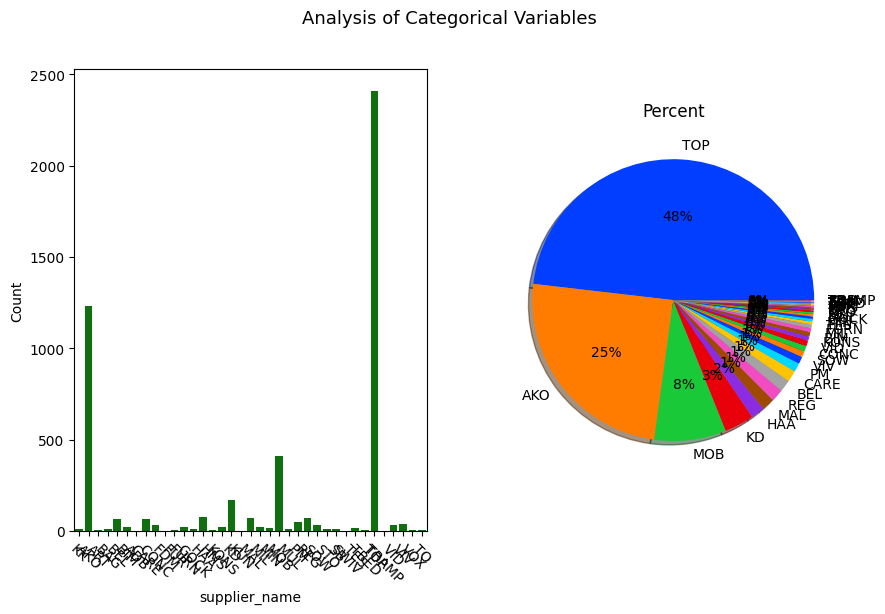

                      order_status  Ratio
order_status                             
shipped                       3551 71.020
awaiting_fulfillment          1377 27.540
cancelled                       72  1.440


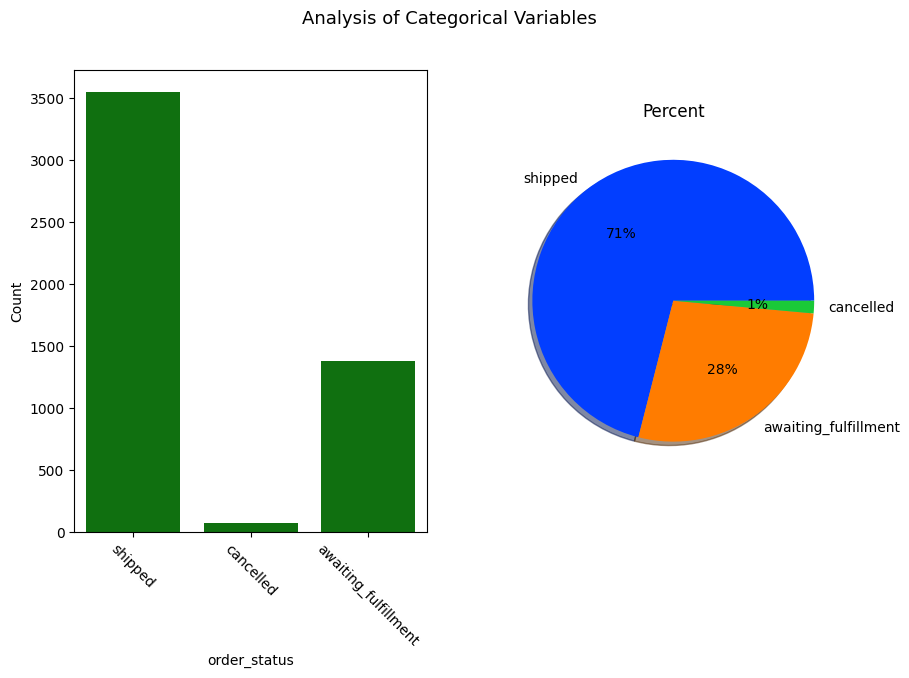

                 cancelled_value  Ratio
cancelled_value                        
0.000                       4928 98.560
105.750                        4  0.080
166.630                        4  0.080
149.920                        4  0.080
112.460                        2  0.040
138.180                        2  0.040
73.130                         2  0.040
109.720                        2  0.040
299.920                        2  0.040
65.750                         2  0.040
191.630                        2  0.040
62.420                         2  0.040
58.250                         2  0.040
91.580                         2  0.040
83.250                         2  0.040
42.410                         2  0.040
63.250                         2  0.040
340.710                        2  0.040
97.520                         2  0.040
133.250                        2  0.040
139.130                        2  0.040
162.420                        2  0.040
214.880                        2  0.040


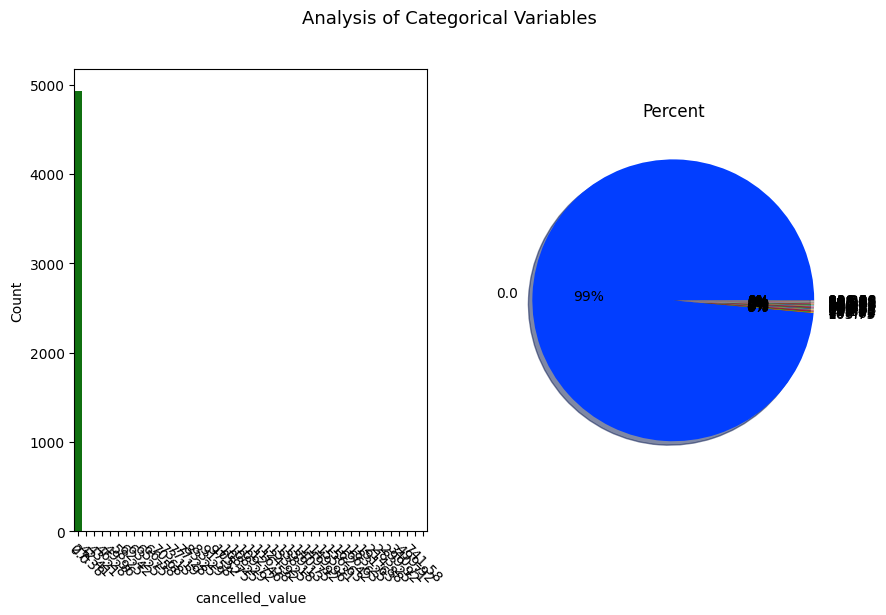

         courier  Ratio
courier                
UPS         1927 38.540
DPD         1490 29.800


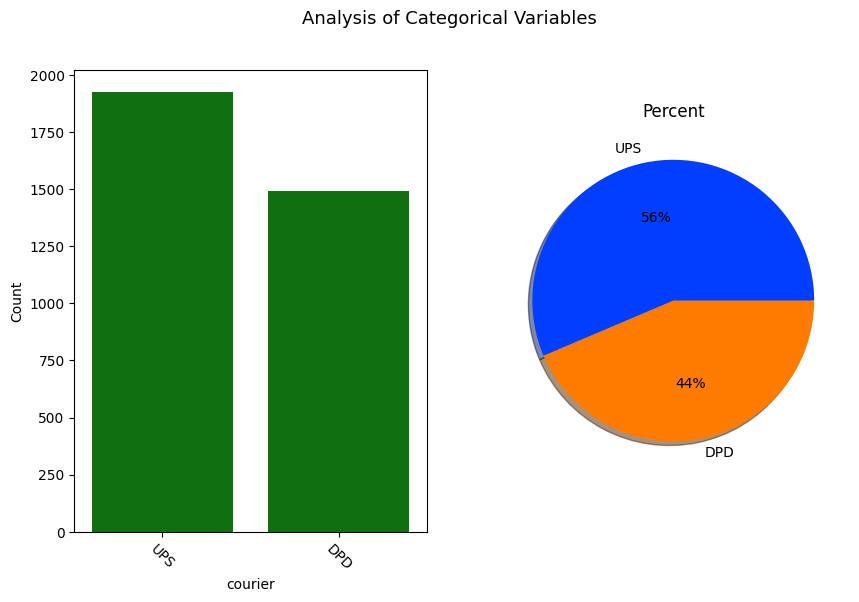

                   max_shipping_date  Ratio
max_shipping_date                          
2020-10-02                       537 10.740
2020-10-09                       483  9.660
2020-09-25                       455  9.100
2020-10-05                       242  4.840
2020-09-23                       233  4.660
2020-10-12                       225  4.500
2020-10-14                       212  4.240
2020-10-01                       210  4.200
2020-09-30                       194  3.880
2020-10-13                       190  3.800
2020-09-29                       170  3.400
2020-10-15                       167  3.340
2020-10-06                       161  3.220
2020-10-07                       159  3.180
2020-10-16                       157  3.140
2020-09-18                       154  3.080
2020-09-28                       147  2.940
2020-09-24                       118  2.360
2020-09-21                       107  2.140
2020-10-08                       103  2.060
2020-09-16                      

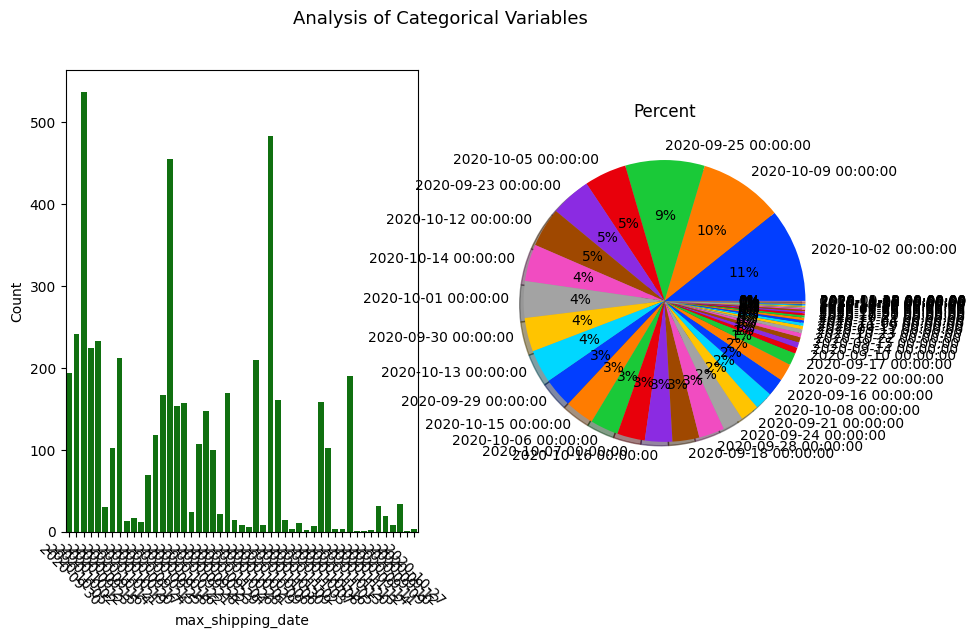

                               cd_status  Ratio
cd_status                                      
WaitingForShipmentAcceptation       2143 42.860
Shipped                              468  9.360
CancelledByCustomer                   33  0.660


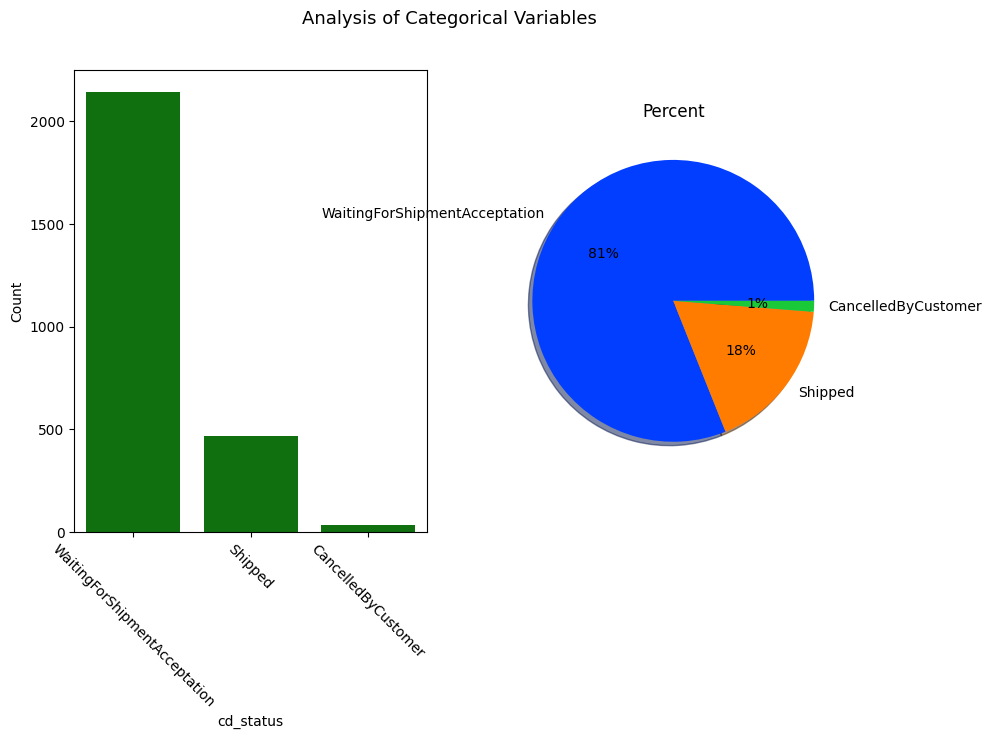

                      is_clogistique_order  Ratio
is_clogistique_order                             
No                                    4573 91.460
Yes                                    427  8.540


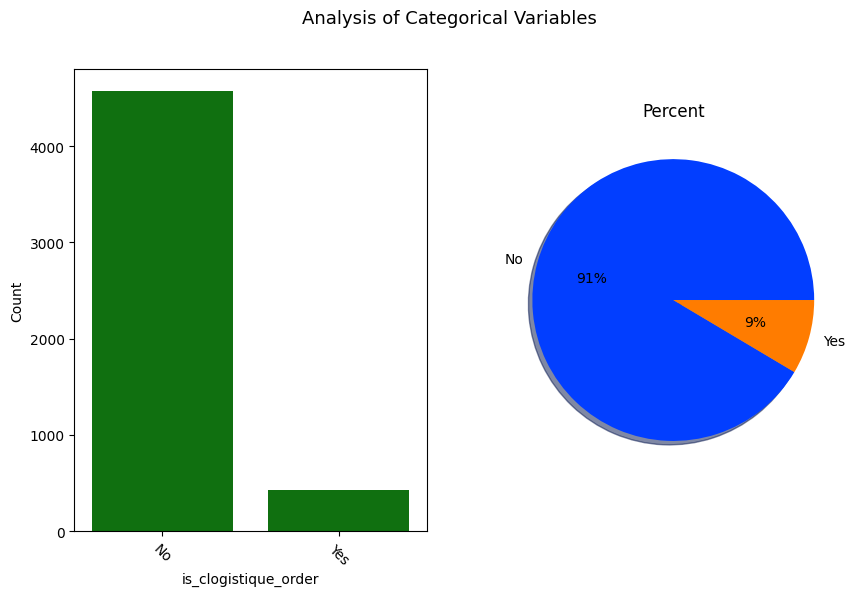

                   line_status  Ratio
line_status                          
Awaiting shipment         3531 70.620
Awaiting Protocol         1397 27.940
Cancelled                   72  1.440


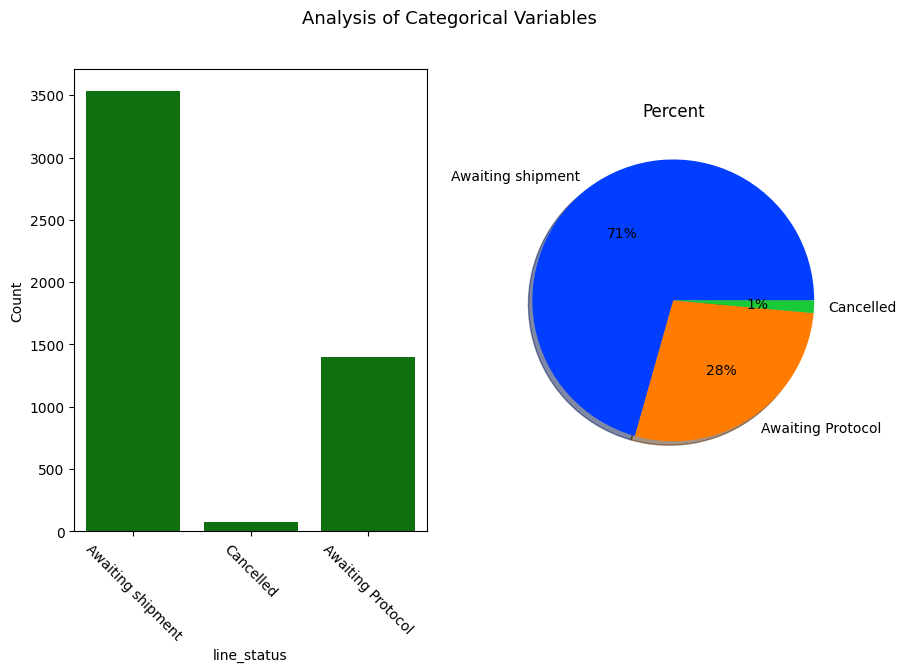

                       transport_cost_actual   Ratio
transport_cost_actual                               
0                                       5000 100.000


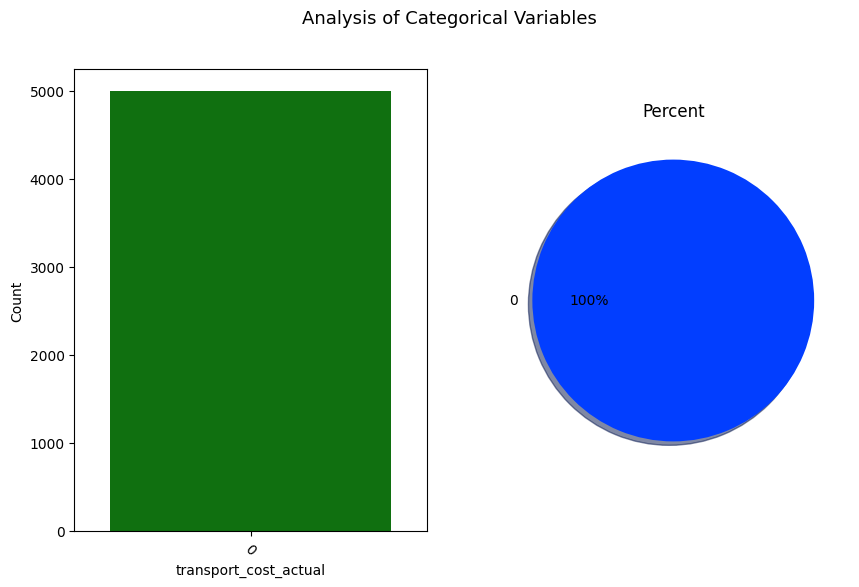

                  order_place_time  Ratio
order_place_time                         
1                             1263 25.260
2                              747 14.940
3                              406  8.120
4                              231  4.620
5                              224  4.480
16                             210  4.200
13                             180  3.600
12                             176  3.520
23                             160  3.200
0                              157  3.140
15                             138  2.760
19                             115  2.300
6                              107  2.140
17                             104  2.080
11                             101  2.020
24                             101  2.020
9                               98  1.960
14                              84  1.680
8                               84  1.680
18                              77  1.540
7                               62  1.240
10                              59

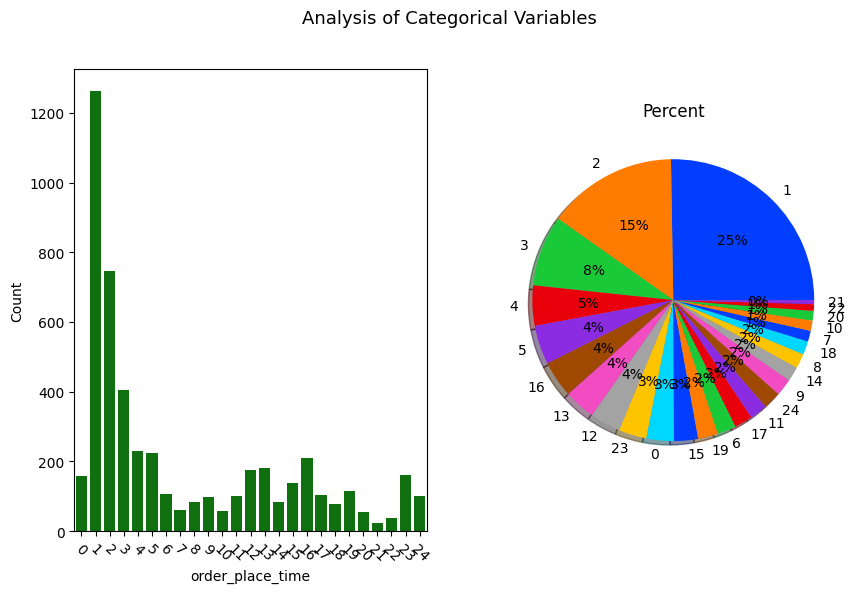

                 order_prep_time  Ratio
order_prep_time                        
 0                          2063 41.260
 1                          1429 28.580
 2                           457  9.140
 3                           410  8.200
 4                           324  6.480
 5                            92  1.840
 7                            75  1.500
 6                            37  0.740
 8                            27  0.540
 10                           19  0.380
 12                            8  0.160
 9                             8  0.160
 14                            6  0.120
 16                            6  0.120
 11                            6  0.120
 19                            6  0.120
-13                            4  0.080
-15                            3  0.060
-8                             3  0.060
-7                             3  0.060
-14                            3  0.060
 15                            2  0.040
 22                            2  0.040


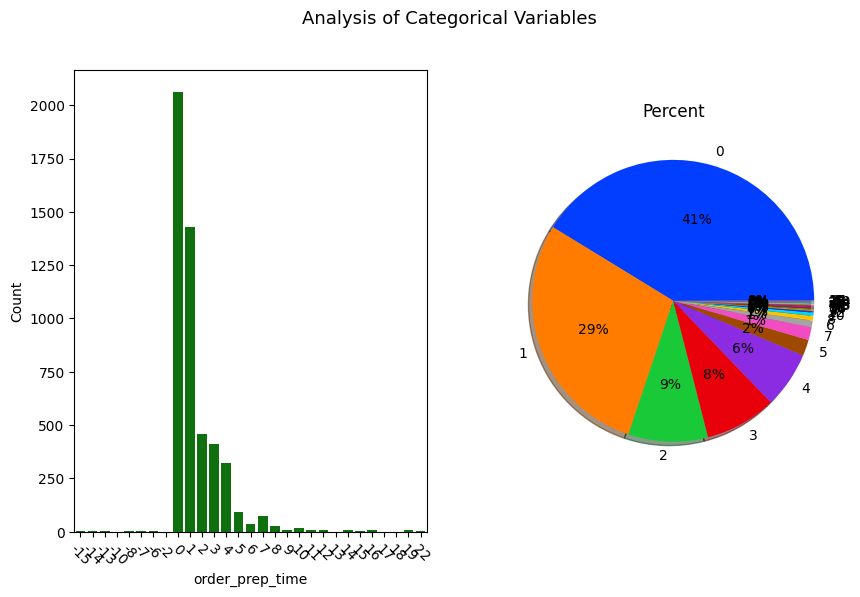

                     order_delivery_time  Ratio
order_delivery_time                            
0                                   2212 44.240
2                                    736 14.720
4                                    681 13.620
3                                    462  9.240
5                                    338  6.760
1                                    329  6.580
6                                     71  1.420
7                                     57  1.140
8                                     37  0.740
11                                    14  0.280
9                                     12  0.240
10                                    10  0.200
13                                     9  0.180
14                                     7  0.140
15                                     7  0.140
17                                     5  0.100
23                                     4  0.080
16                                     4  0.080
22                                     2

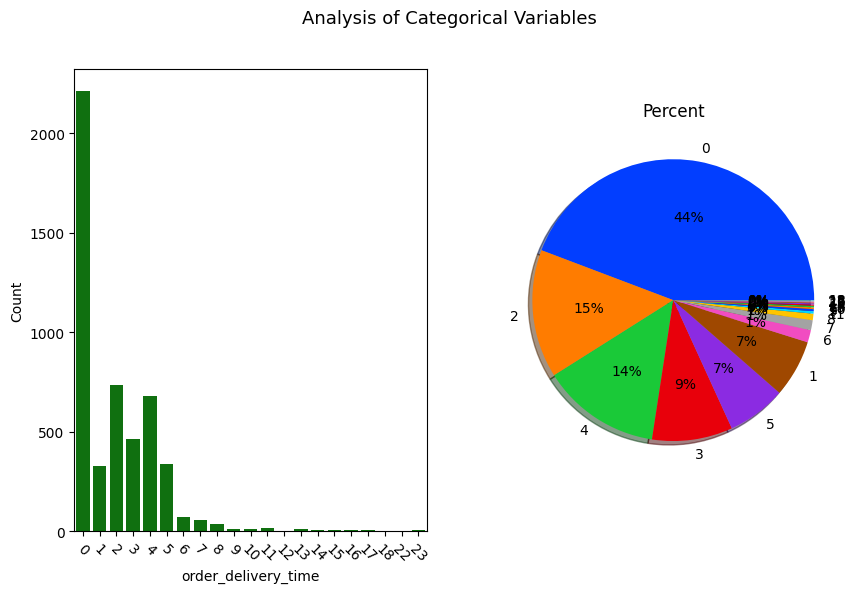

                  order_total_time  Ratio
order_total_time                         
3                              456  9.120
4                              390  7.800
5                              379  7.580
2                              308  6.160
8                              303  6.060
6                              303  6.060
9                              262  5.240
7                              260  5.200
10                             166  3.320
23                             159  3.180
0                              157  3.140
21                             149  2.980
16                             145  2.900
13                             139  2.780
1                              132  2.640
11                             125  2.500
22                             123  2.460
14                             118  2.360
15                             107  2.140
12                             104  2.080
17                             101  2.020
20                              89

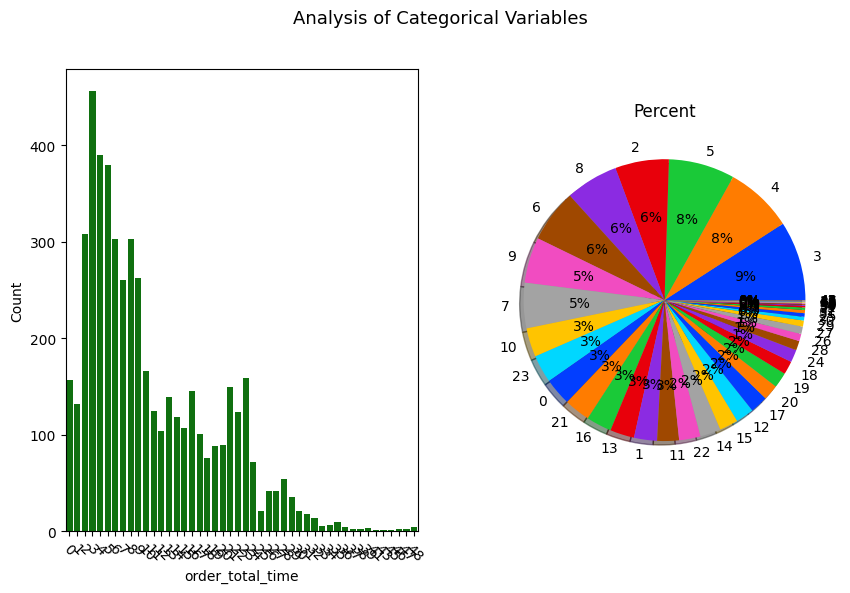

             order_month  Ratio
order_month                    
9                   4533 90.660
10                   467  9.340


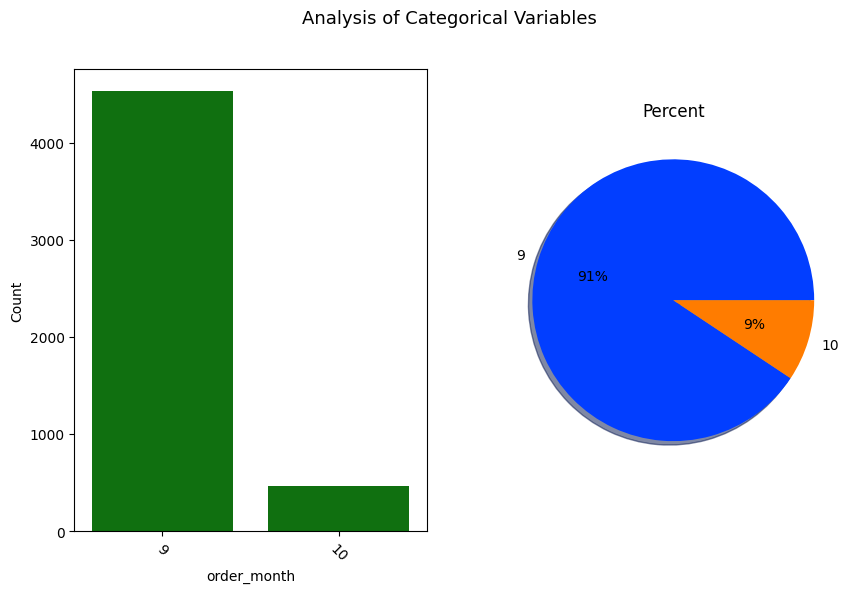

            order_week  Ratio
order_week                   
40                1531 30.620
38                1523 30.460
39                1163 23.260
37                 783 15.660


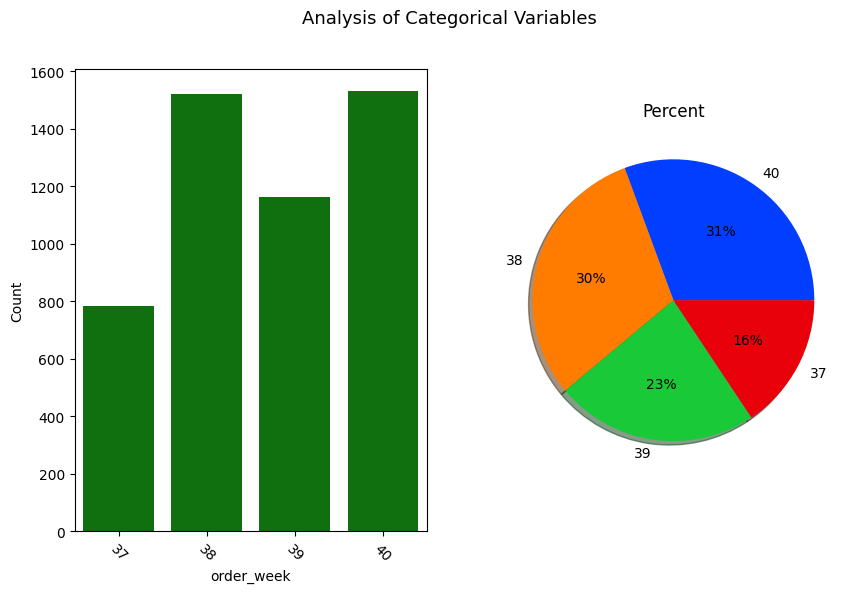

            order_year   Ratio
order_year                    
2020              5000 100.000


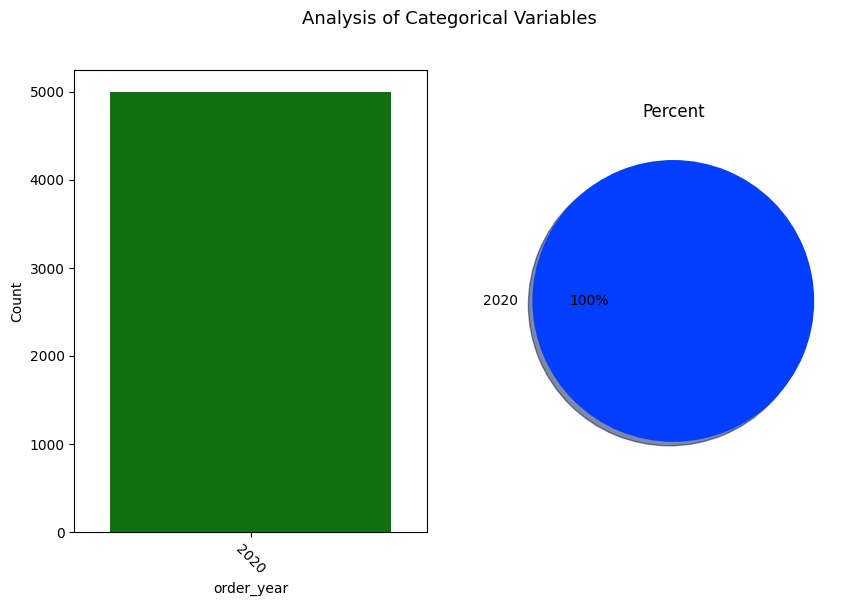

            order_hour  Ratio
order_hour                   
15                 392  7.840
16                 386  7.720
14                 351  7.020
19                 338  6.760
17                 330  6.600
10                 319  6.380
12                 317  6.340
13                 313  6.260
18                 304  6.080
8                  303  6.060
11                 292  5.840
9                  286  5.720
20                 273  5.460
7                  222  4.440
21                 166  3.320
6                  146  2.920
5                   92  1.840
22                  63  1.260
4                   37  0.740
23                  28  0.560
2                   13  0.260
3                   12  0.240
0                   12  0.240
1                    5  0.100


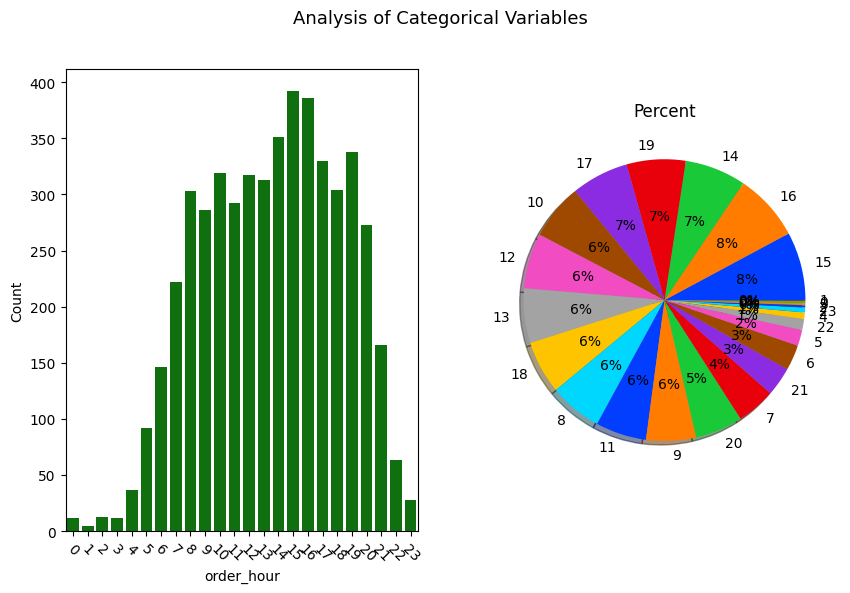

In [74]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

## NUMERICAL COLUMNS ANALYSIS

In [75]:
def num_summary(dataframe, numerical_col):
    # setup the plot grid
    fig, ax = plt.subplots(1, 2)
    ax = np.reshape(ax, (1, 2))
    ax[0, 0] = sns.histplot(x=dataframe[numerical_col], color="blue", bins=20, ax=ax[0, 0])
    ax[0, 0].set_ylabel('Count')
    ax[0, 0].set_title('Distribution')
    ax[0, 1] = sns.boxplot(y=dataframe[numerical_col], color="blue", ax=ax[0, 1])
    ax[0, 1].set_title('Quantiles')

    fig.set_size_inches(12, 8)
    fig.suptitle('Analysis of Numerical Variables', fontsize=13)
    plt.show()

In [76]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   mkp_order_no              5000 non-null   object        
 1   order_date                5000 non-null   datetime64[ns]
 2   ordoro_id                 5000 non-null   object        
 3   sku                       5000 non-null   object        
 4   item_sale_price           5000 non-null   float64       
 5   total_per_sku             5000 non-null   float64       
 6   item_cost                 5000 non-null   float64       
 7   transport_cost_est        5000 non-null   float64       
 8   first_pick_date           5000 non-null   object        
 9   last_delivery_date        5000 non-null   object        
 10  mage_mkp_commission       5000 non-null   float64       
 11  mkp_estimated_commission  5000 non-null   float64       
 12  mkp_actual_commissio

In [77]:
df[num_cols].head()

,mkp_order_no,order_date,ordoro_id,sku,item_sale_price,total_per_sku,item_cost,transport_cost_est,first_pick_date,last_delivery_date,mage_mkp_commission,mkp_estimated_commission,mkp_actual_commission,order_grand_total,ordoro_import_date,tool_import_date,max_delivery_date,gm_estimated
0,2009161727KUPJE,2020-09-16 15:27:00,1-300055647,KK-KKLJOYBLU00000,69.950,79.900,0.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,1.920,0.000,13.900,81.820,2020-09-16 19:46:00,2020-09-16 19:51:00,2020-10-09,51.080
1,2009161727KUPJE,2020-09-16 15:27:00,1-300055647,KK-KKLJOYBLU00000,69.950,79.900,0.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,1.920,0.000,13.900,81.820,2020-09-16 19:46:00,2020-09-16 19:51:00,2020-10-09,51.080
2,322836927,2020-09-24 22:25:00,1-300056586,KK-KKWMOOVNAV0000,319.950,319.950,171.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,0.000,47.990,0.000,319.950,2020-09-25 00:49:00,2020-09-25 00:51:00,2020-10-08,47.640
3,M200923734296,2020-09-25 08:47:00,1-300056600,KK-KKLJOYBLU000AC,79.950,79.950,0.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,0.000,11.990,0.000,79.950,2020-09-25 12:02:00,2020-09-25 12:10:00,2020-10-13,54.640
4,M200923740097,2020-09-25 13:11:00,1-300056647,KK-KKLJOYBLU000AC,79.950,79.950,0.000,0.000,0000-00-00 00:00:00,0000-00-00 00:00:00,0.000,11.990,0.000,79.950,2020-09-25 15:22:00,2020-09-25 15:30:00,2020-10-13,54.640


In [78]:
cols_not_num = ['mkp_order_no', 'ordoro_id','order_date', 'sku', 'first_pick_date', 'last_delivery_date', 'order_grand_total', 'ordoro_import_date', 'tool_import_date','max_delivery_date']
num_cols = list(filter(lambda x: x not in cols_not_num, num_cols))


In [79]:
num_cols

['item_sale_price',
 'total_per_sku',
 'item_cost',
 'transport_cost_est',
 'mage_mkp_commission',
 'mkp_estimated_commission',
 'mkp_actual_commission',
 'gm_estimated']

item_sale_price


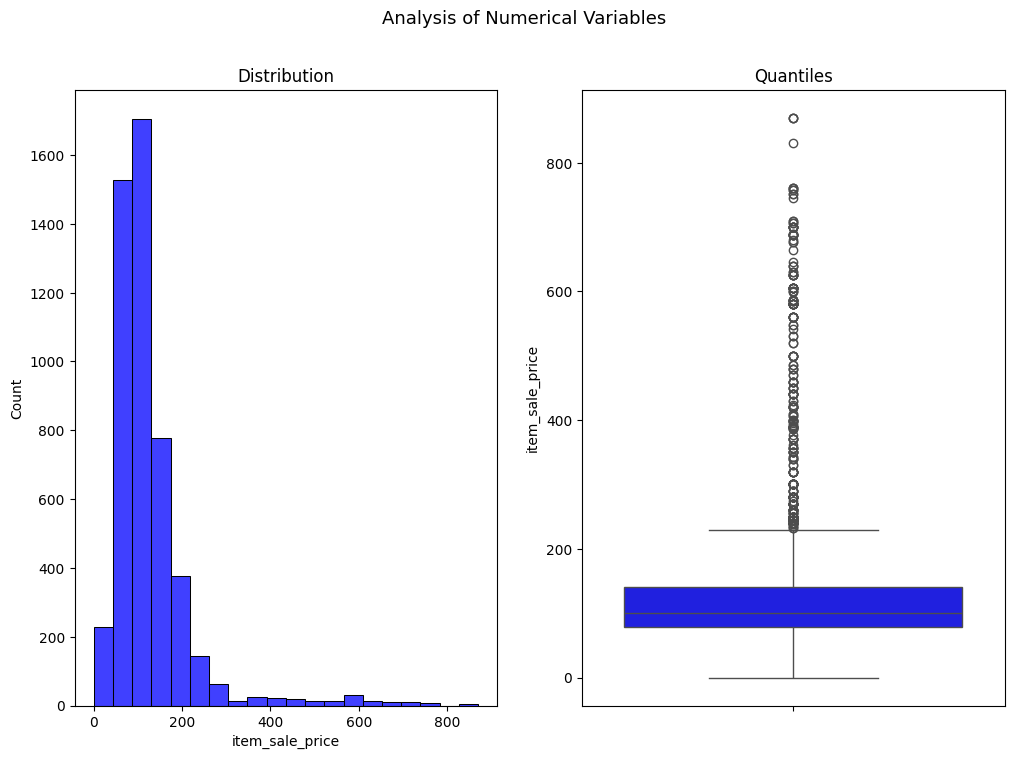

total_per_sku


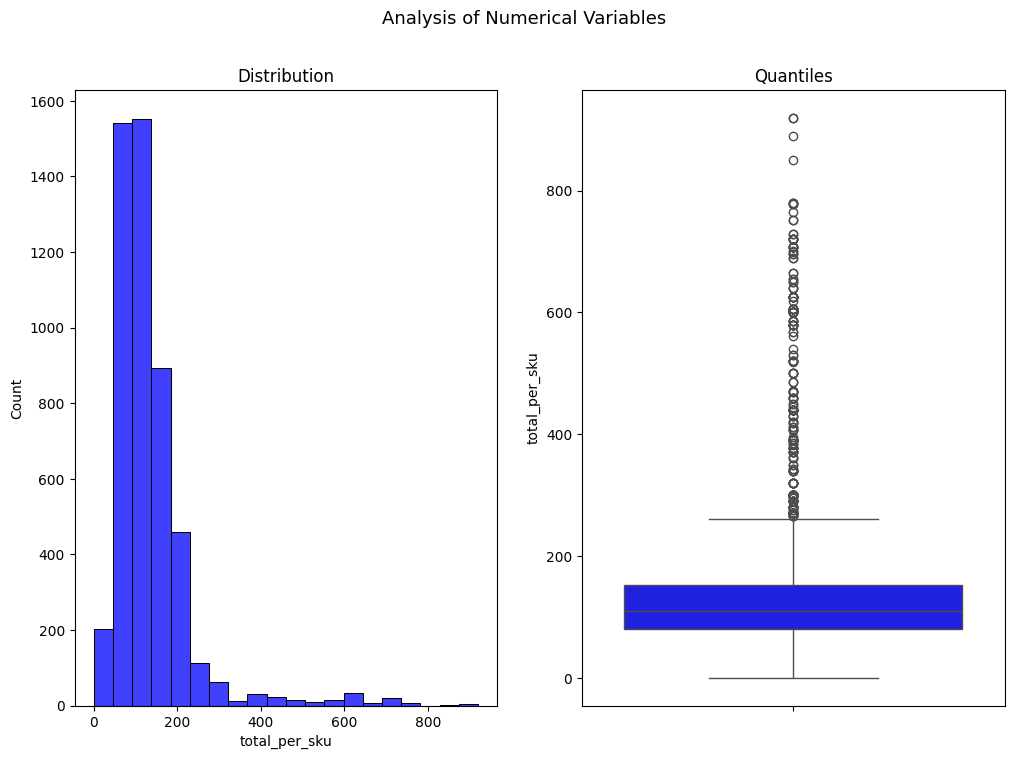

item_cost


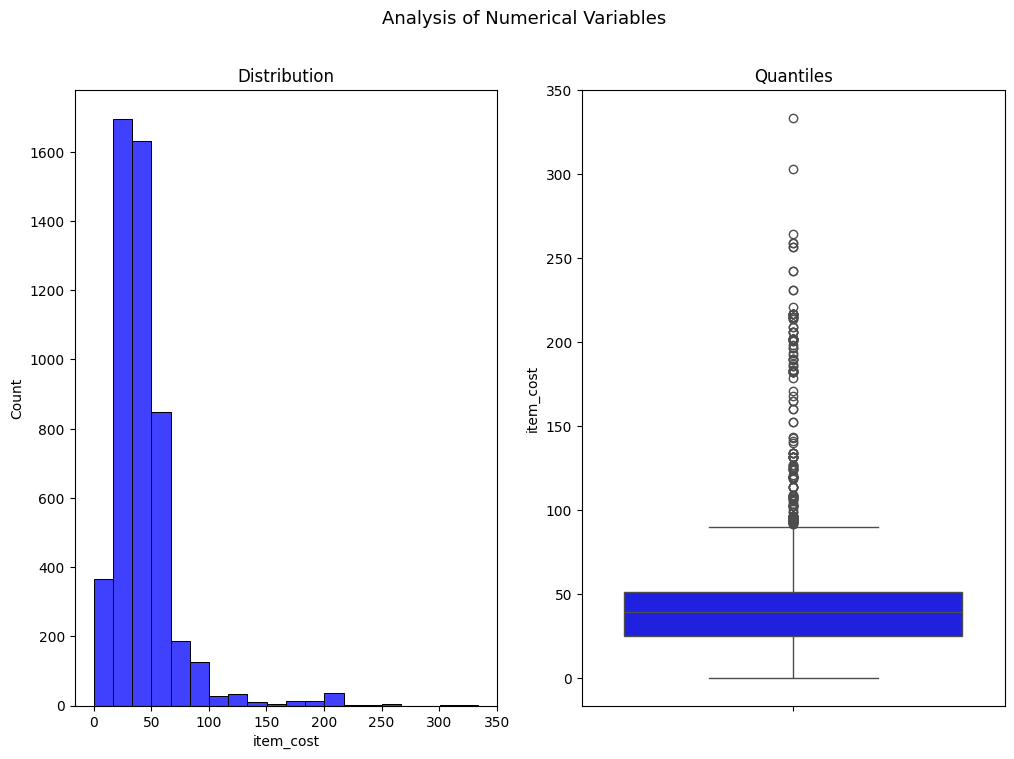

transport_cost_est


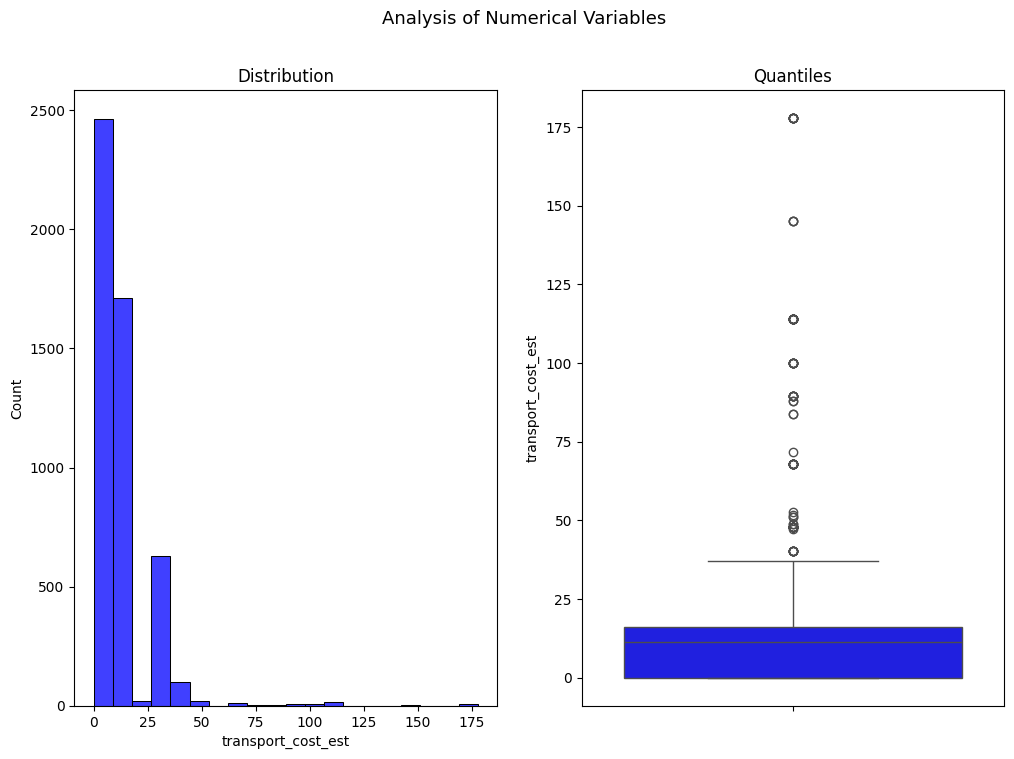

mage_mkp_commission


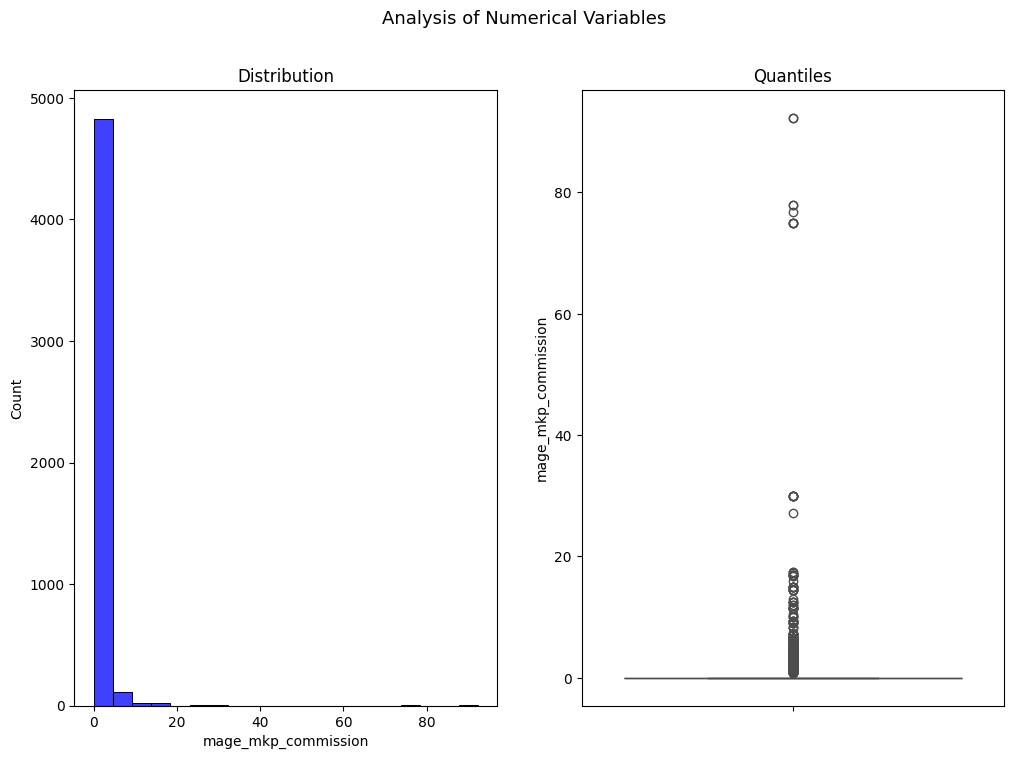

mkp_estimated_commission


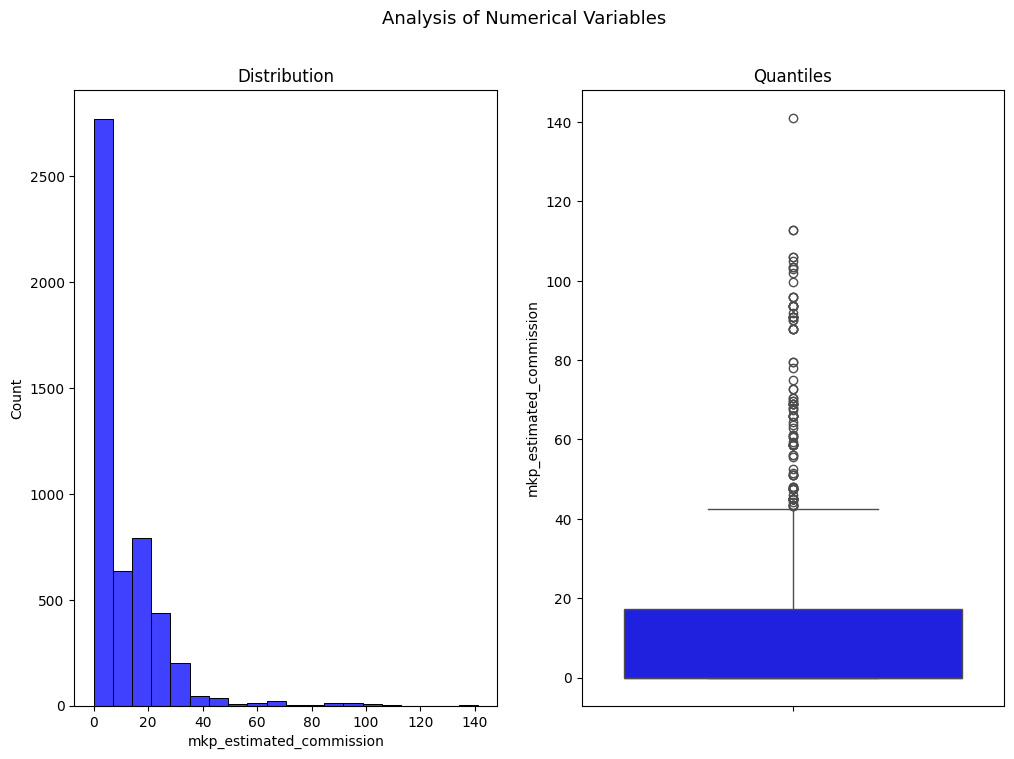

mkp_actual_commission


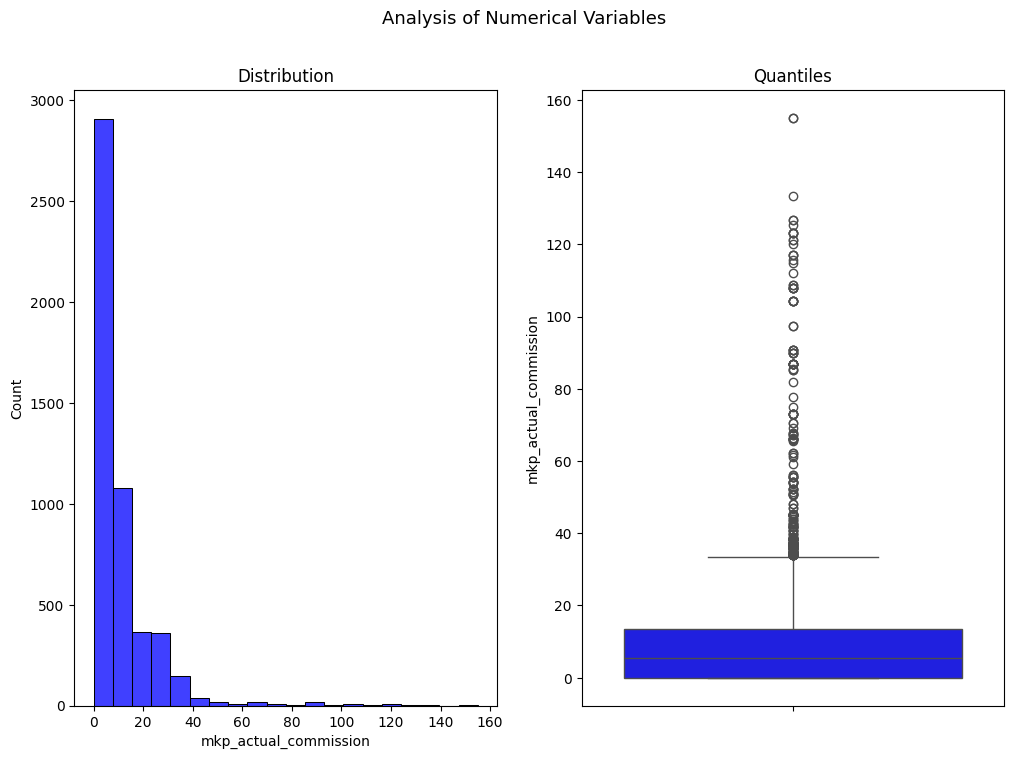

gm_estimated


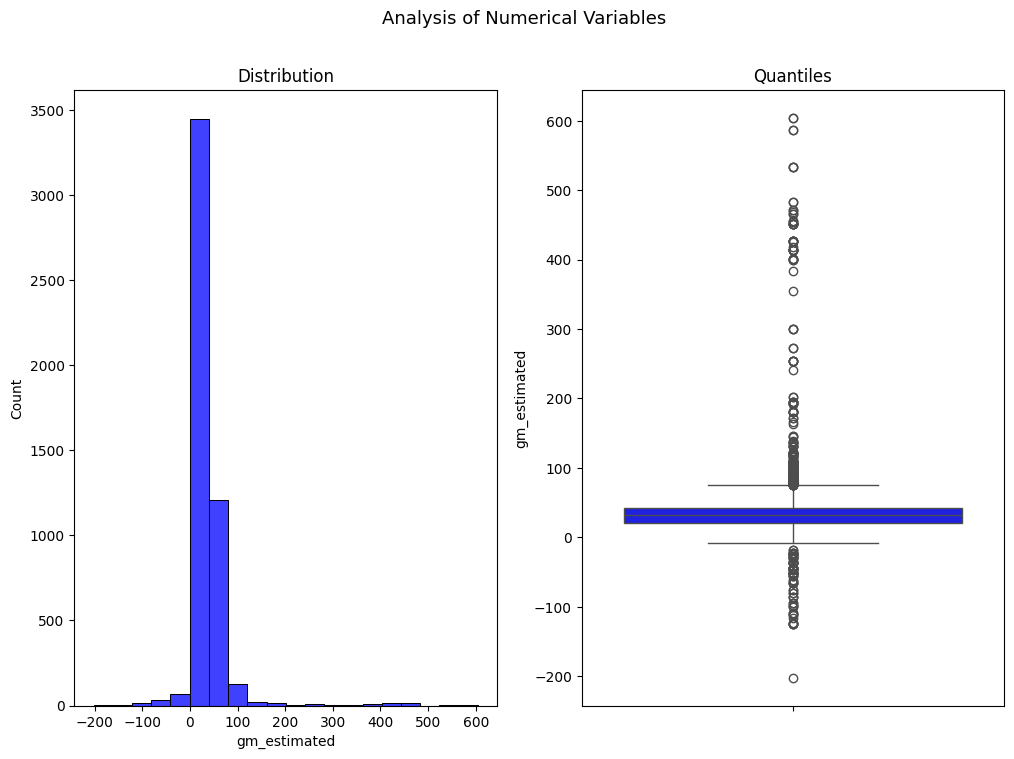

In [80]:
for col in num_cols:
    print(col)
    num_summary(df, col)

In [81]:
###################################### FEATURE ENGINEERING ######################################

In [82]:
###################################### EXPLORATORY DATA ANALYSIS ######################################

<Axes: xlabel='order_hour', ylabel='count'>

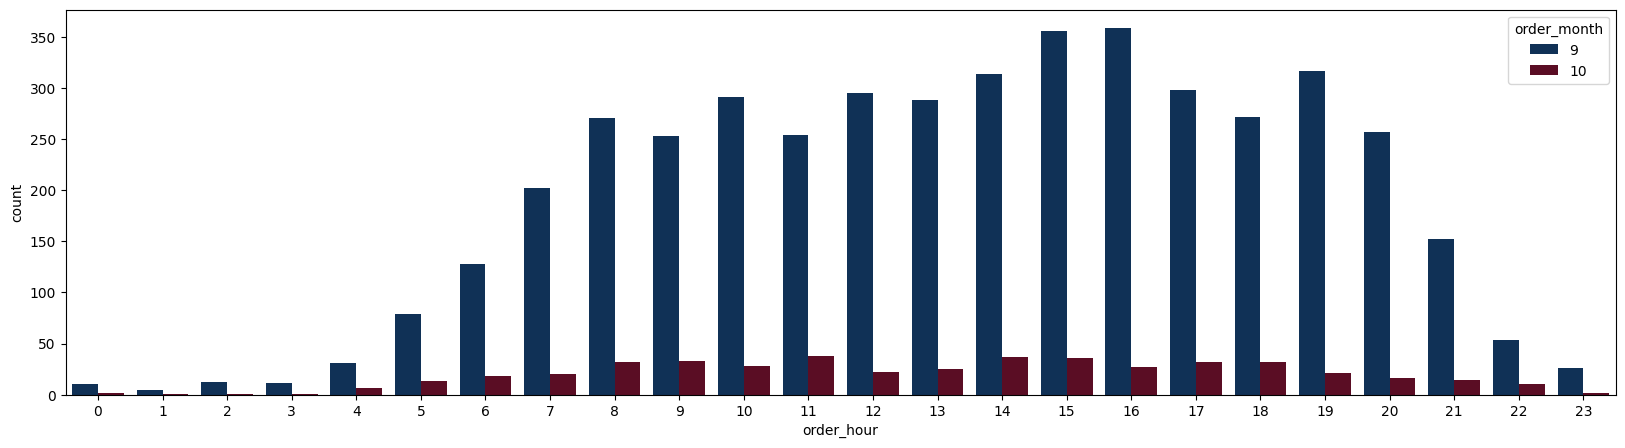

In [83]:
plt.figure(figsize=(20,5))
sns.countplot(x='order_hour', hue='order_month', data=df, palette='RdBu_r')

Text(0.5, 1.0, 'Sales per order status')

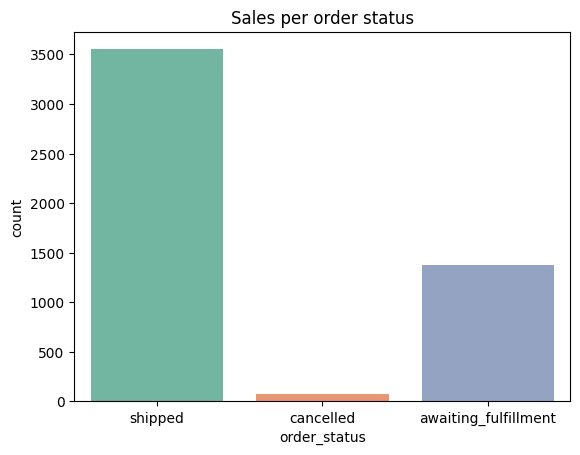

In [84]:
sns.countplot(x='order_status', data=df, palette='Set2')
plt.title('Sales per order status')

Text(0.5, 1.0, 'Sales per line status')

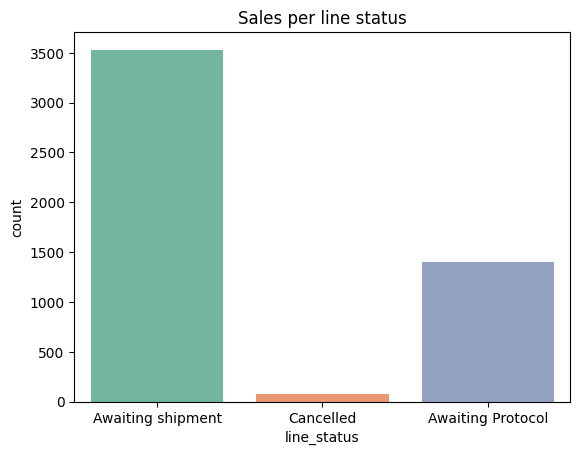

In [85]:
sns.countplot(x='line_status', data=df, palette='Set2')
plt.title('Sales per line status')


Text(0.5, 1.0, 'Sales per courier')

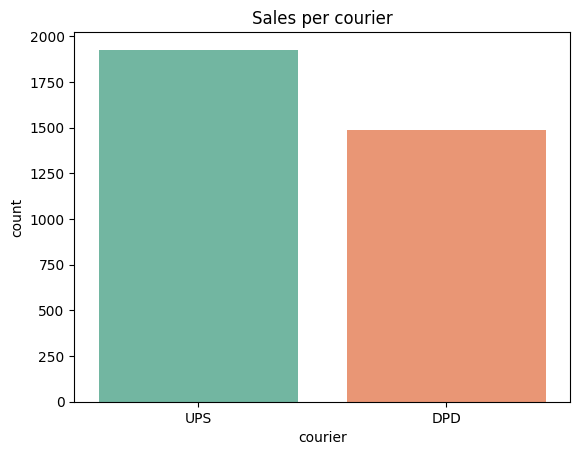

In [86]:
sns.countplot(x='courier', data=df, palette='Set2')
plt.title('Sales per courier')

Text(0.5, 1.0, 'Sales per line type')

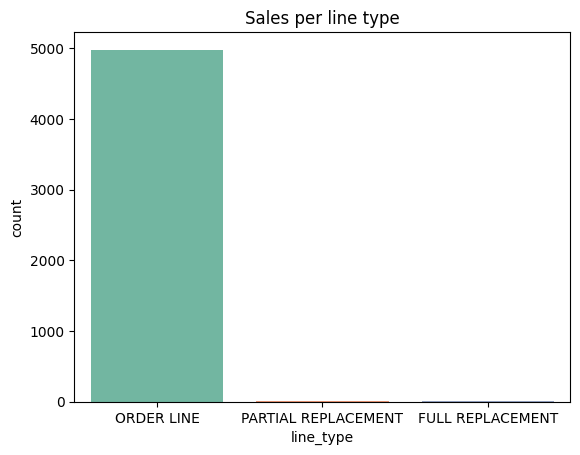

In [87]:
sns.countplot(x='line_type', data=df, palette='Set2')
plt.title('Sales per line type')

Text(0.5, 1.0, 'Sales per item tax')

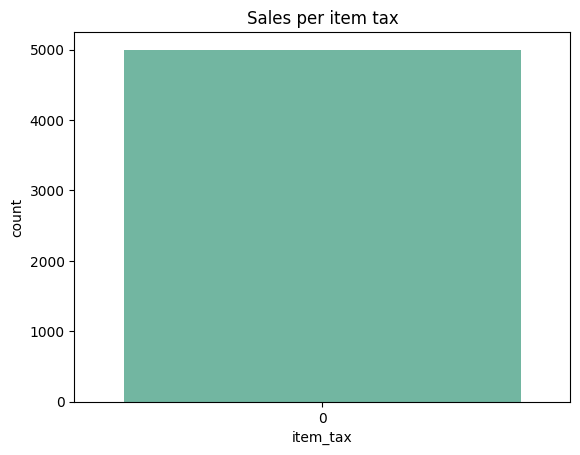

In [88]:
sns.countplot(x='item_tax', data=df, palette='Set2')
plt.title('Sales per item tax')

Text(0.5, 1.0, 'Sales per is_clogistique_order')

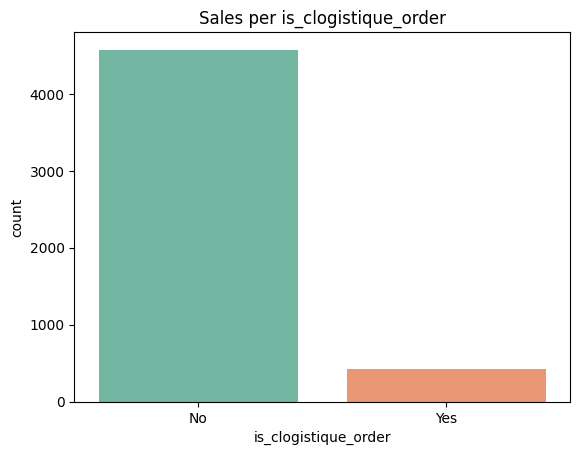

In [89]:
sns.countplot(x='is_clogistique_order', data=df, palette='Set2')
plt.title('Sales per is_clogistique_order')

Text(0.5, 1.0, 'Sales per transport_cost_actual')

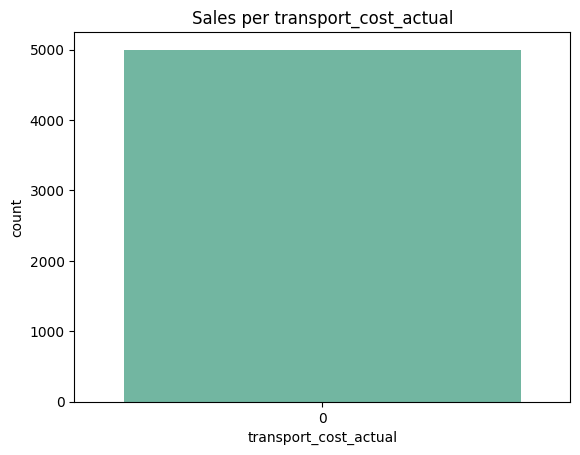

In [90]:
sns.countplot(x='transport_cost_actual', data=df, palette='Set2')
plt.title('Sales per transport_cost_actual')

In [91]:
###################################### FEATURE ENGINEERING ######################################

In [92]:
### Columns to Drop ###

# transport_cost_actual (all zero), 
# item_tax (all zero), 
# line_type (Almost all rows contain same info), 
# line_status (keeps same info with order_status)